### 🎯 HÜCRE 1: Kütüphane Yükleme ve Ortam Hazırlığı

Bu hücrede, projenin tamamında kullanılacak olan **temel Python, veri bilimi ve derin öğrenme kütüphaneleri** (TensorFlow, Keras, Sklearn, Matplotlib vb.) yüklenir.

Ayrıca, proje genelinde **tekrar üretilebilirliği (reproducibility)** sağlamak amacıyla rastgelelik (randomness) tohumları (`seed=42`) ayarlanır. Bu, kodun her çalıştırılışında aynı sonuçları üretme şansını artırır.

In [55]:
# =========================================
# HÜCRE 1: TÜM KÜTÜPHANE İMPORTLARI 
# =========================================

# Temel Kütüphaneler ve Ayarlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
import json
import math
from collections import Counter
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, BatchNormalization, GlobalAveragePooling2D,
                                     Input, Activation, 
                                     # Hücre 5'ten gelen Augmentation/Preprocessing Katmanları
                                     Rescaling, RandomRotation, RandomZoom, 
                                     RandomTranslation, RandomFlip, RandomContrast)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers

# Uygulama Modelleri (Transfer Learning ve Kıyaslama için)
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, MobileNetV2 

# Keras Metrikleri (Top-3 Accuracy için kritik)
from tensorflow.keras.metrics import top_k_categorical_accuracy 

# Sklearn (Değerlendirme metrikleri)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Görselleştirme için ek
import matplotlib.image as mpimg
import itertools

# --- Başlangıç Ayarları ---
plt.style.use('default')
sns.set_palette("husl")
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("🚀 Akbank Derin Öğrenme Bootcamp - Car Brand Classification")
print("="*60)
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("✅ Tüm kütüphaneler başarıyla yüklendi!")

🚀 Akbank Derin Öğrenme Bootcamp - Car Brand Classification
TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Tüm kütüphaneler başarıyla yüklendi!


### 📝 HÜCRE 2 & 3: Veri Yolları Tanımlama ve Veri Keşfi (EDA)

Bu aşamada:
1.  **Veri Kök Yolu** tanımlanır ve projenin çalışacağı ortamdaki (`/kaggle/input/` veya benzeri) klasör yapısı belirlenir.
2.  `train`, `validation` ve `test` setlerinin dosya yolları (`train_path`, `val_path`, `test_path`) oluşturulur.
3.  **Sınıf Dağılımı** (Car Brand Counts) hesaplanır ve listelenir. Bu, veri setindeki **sınıf dengesizliğini** (Class Imbalance) tespit etmek ve bir sonraki aşamada **sınıf ağırlıkları (`class_weights`)** hesaplamak için kritik öneme sahiptir.

In [12]:
# =========================================
# HÜCRE 2: DATASET YOLU VE SINIF ANALİZİ
# =========================================
print("\n📁 Dataset Yapısı Analizi")
print("="*40)

# Dataset ana yolu
dataset_path = "/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset"

# Train / Validation / Test yolları
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val") 
test_path = os.path.join(dataset_path, "test")

# Dosya yapısını kontrol et
for path_name, path in [("Train", train_path), ("Validation", val_path), ("Test", test_path)]:
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"{exists} {path_name} Path: {path}")

# Sınıf isimlerini çıkar
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

print(f"\n📊 Dataset Özeti:")
print(f"├── Toplam Sınıf Sayısı: {num_classes}")
print(f"├── İlk 10 Sınıf: {class_names[:10]}")
print(f"└── Son 5 Sınıf: {class_names[-5:]}")


📁 Dataset Yapısı Analizi
✅ Train Path: /kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset/train
✅ Validation Path: /kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset/val
✅ Test Path: /kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset/test

📊 Dataset Özeti:
├── Toplam Sınıf Sayısı: 33
├── İlk 10 Sınıf: ['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge']
└── Son 5 Sınıf: ['Ram', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo']



📊 Sınıf Bazında Veri Dağılımı Analizi
📈 Veri İstatistikleri:
├── Toplam Görüntü: 16,467
├── Ortalama/Sınıf: 499
├── En Az: Acura (499 görüntü)
└── En Çok: Acura (499 görüntü)


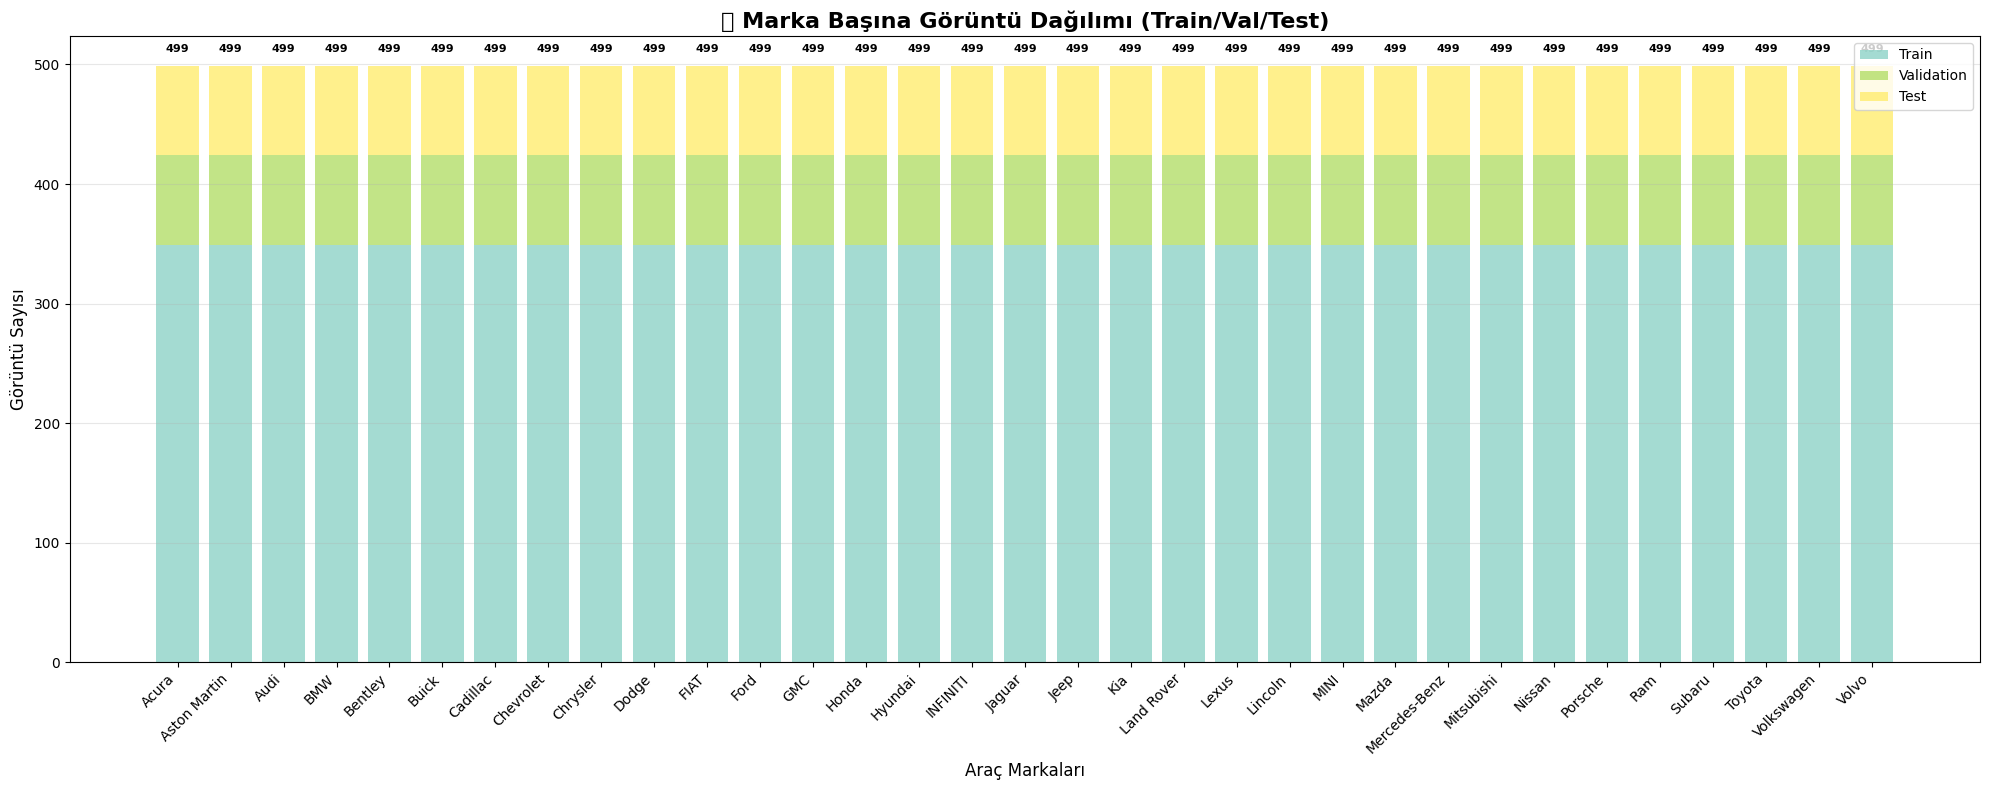


🏆 En Çok Görüntüye Sahip 10 Marka:
 1. Acura          :  499 görüntü
 2. Aston Martin   :  499 görüntü
 3. Audi           :  499 görüntü
 4. BMW            :  499 görüntü
 5. Bentley        :  499 görüntü
 6. Buick          :  499 görüntü
 7. Cadillac       :  499 görüntü
 8. Chevrolet      :  499 görüntü
 9. Chrysler       :  499 görüntü
10. Dodge          :  499 görüntü

⚠️ En Az Görüntüye Sahip 10 Marka:
 1. Mazda          :  499 görüntü
 2. Mercedes-Benz  :  499 görüntü
 3. Mitsubishi     :  499 görüntü
 4. Nissan         :  499 görüntü
 5. Porsche        :  499 görüntü
 6. Ram            :  499 görüntü
 7. Subaru         :  499 görüntü
 8. Toyota         :  499 görüntü
 9. Volkswagen     :  499 görüntü
10. Volvo          :  499 görüntü


In [13]:
# =========================================
# HÜCRE 3: SINIF BAŞINA GÖRSEL SAYISI ANALİZİ VE GÖRSELLEŞTİRME
# =========================================
print("\n📊 Sınıf Bazında Veri Dağılımı Analizi")
print("="*50)

# Her sınıf için train/val/test sayılarını hesapla
train_counts = []
val_counts = []
test_counts = []
total_counts = []

for cls in class_names:
    train_count = len(os.listdir(os.path.join(train_path, cls)))
    val_count = len(os.listdir(os.path.join(val_path, cls)))
    test_count = len(os.listdir(os.path.join(test_path, cls)))
    
    train_counts.append(train_count)
    val_counts.append(val_count)
    test_counts.append(test_count)
    total_counts.append(train_count + val_count + test_count)

# İstatistikler
total_images = sum(total_counts)
avg_per_class = total_images // num_classes
min_class_idx = np.argmin(total_counts)
max_class_idx = np.argmax(total_counts)

print(f"📈 Veri İstatistikleri:")
print(f"├── Toplam Görüntü: {total_images:,}")
print(f"├── Ortalama/Sınıf: {avg_per_class}")
print(f"├── En Az: {class_names[min_class_idx]} ({total_counts[min_class_idx]} görüntü)")
print(f"└── En Çok: {class_names[max_class_idx]} ({total_counts[max_class_idx]} görüntü)")

# Rengarenk stacked bar chart
plt.figure(figsize=(20, 8))
width = 0.8

# Renkli palette
colors = plt.cm.Set3(np.linspace(0, 1, 3))

# Stacked bar chart
p1 = plt.bar(class_names, train_counts, width, label='Train', color=colors[0], alpha=0.8)
p2 = plt.bar(class_names, val_counts, width, bottom=train_counts, label='Validation', color=colors[1], alpha=0.8)
p3 = plt.bar(class_names, test_counts, width, bottom=np.array(train_counts) + np.array(val_counts), 
             label='Test', color=colors[2], alpha=0.8)

plt.title('🚗 Marka Başına Görüntü Dağılımı (Train/Val/Test)', fontsize=16, fontweight='bold')
plt.ylabel('Görüntü Sayısı', fontsize=12)
plt.xlabel('Araç Markaları', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)

# Değerleri bar üzerine yaz
for i, (train, val, test) in enumerate(zip(train_counts, val_counts, test_counts)):
    total = train + val + test
    plt.text(i, total + 10, str(total), ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Top 10 ve Bottom 10 sınıfları göster
sorted_classes = sorted(zip(class_names, total_counts), key=lambda x: x[1], reverse=True)

print(f"\n🏆 En Çok Görüntüye Sahip 10 Marka:")
for i, (cls, count) in enumerate(sorted_classes[:10], 1):
    print(f"{i:2d}. {cls:15s}: {count:4d} görüntü")

print(f"\n⚠️ En Az Görüntüye Sahip 10 Marka:")
for i, (cls, count) in enumerate(sorted_classes[-10:], 1):
    print(f"{i:2d}. {cls:15s}: {count:4d} görüntü")

### ⚖️ HÜCRE 4: Sınıf Ağırlıkları (Class Weights) ve Temel Hiperparametreler

Bu hücrede:
1.  **Temel Hiperparametreler** (Görüntü Boyutu, Batch Size, Learning Rate, Epochs vb.) tanımlanır.
2.  Önceki hücrede tespit edilen **sınıf dengesizliğini gidermek** amacıyla `class_weights` hesaplanır. Bu ağırlıklar, az sayıdaki sınıflara ait görüntülerin eğitim sırasında daha büyük bir etki yaratmasını sağlayarak modelin genelleme başarısını artırır.


🖼️ Örnek Görüntü Galerisi


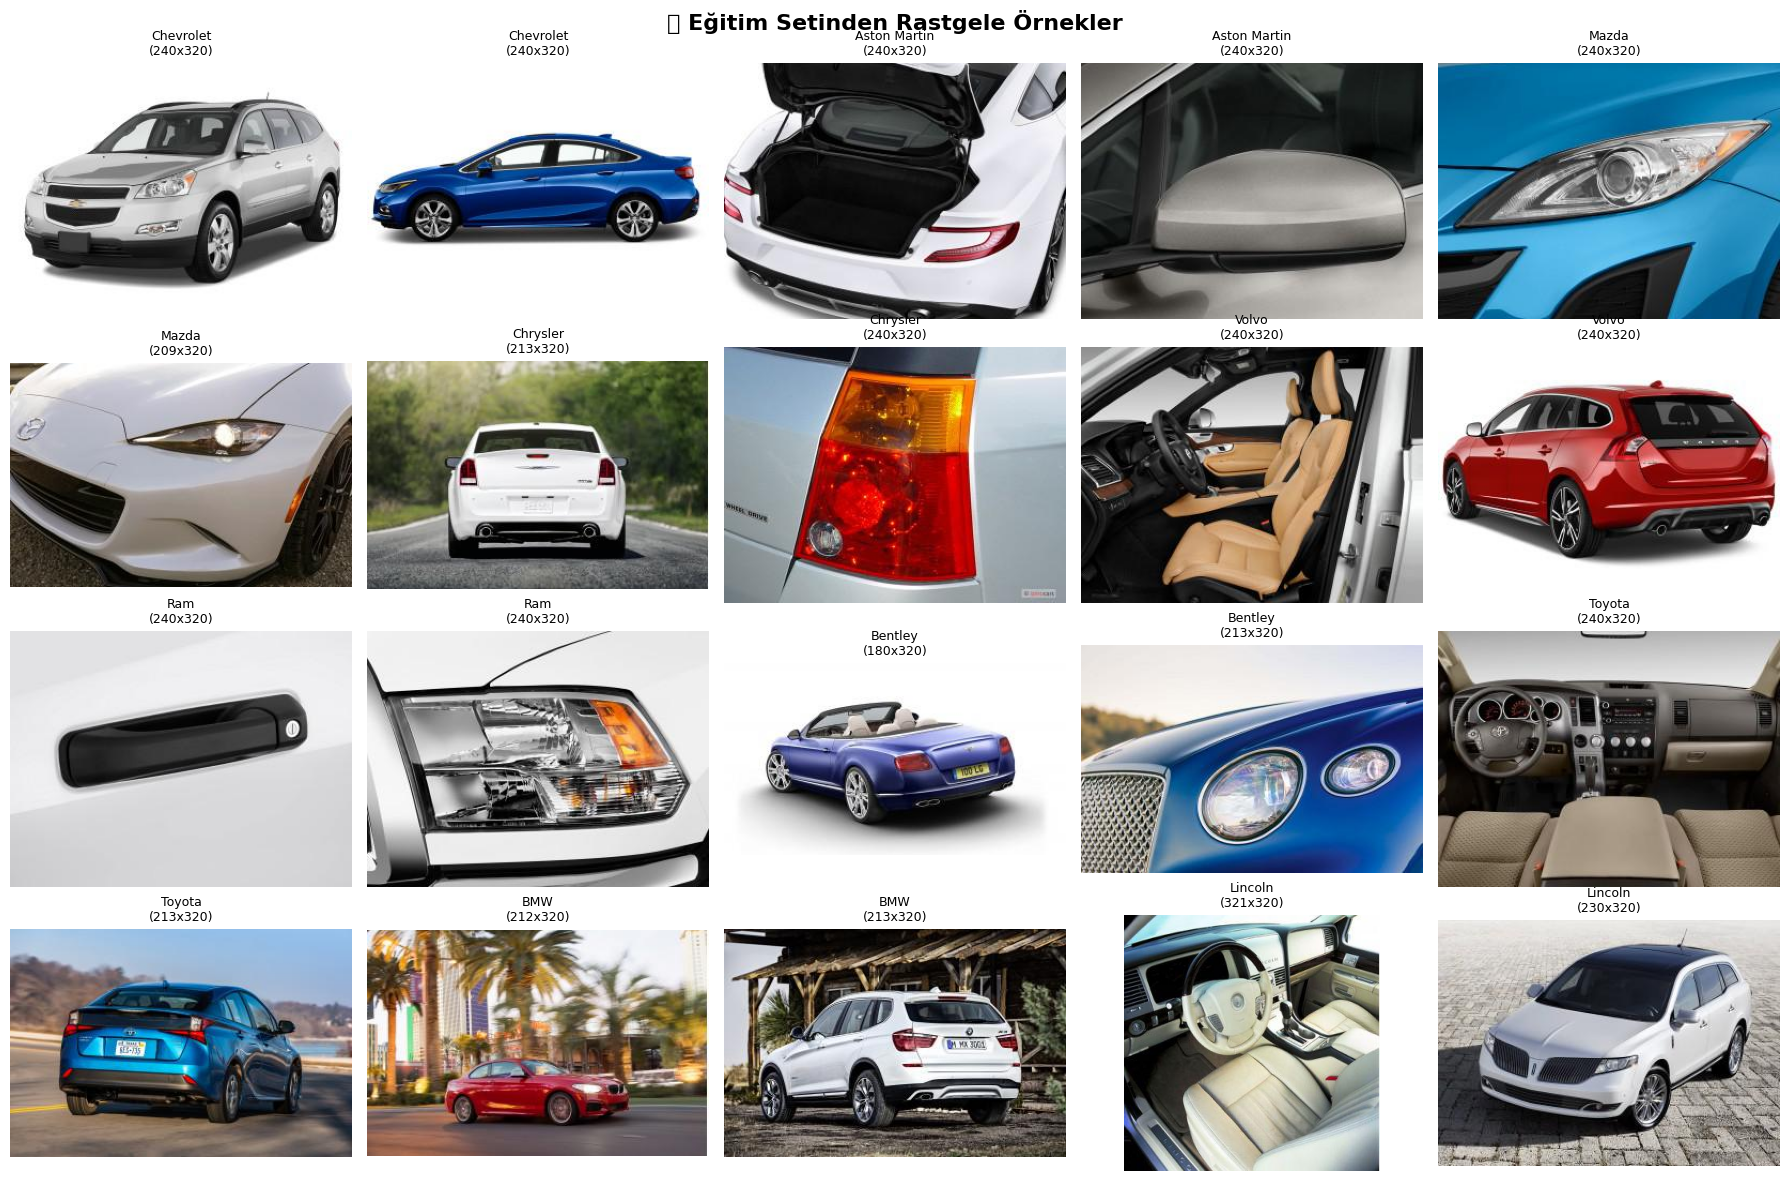


📐 Görüntü Boyut Analizi (İlk 50 görüntü):
├── Ortalama Genişlik: 320px
├── Ortalama Yükseklik: 223px
├── Min Boyut: 320x150
└── Max Boyut: 320x426


In [14]:
# =========================================
# HÜCRE 4: RASTGELE ÖRNEK GÖRÜNTÜLERİ GÖSTERME
# =========================================
print(f"\n🖼️ Örnek Görüntü Galerisi")
print("="*30)

# 10 rastgele sınıf seç (daha dengeli görünüm için)
num_classes_to_show = min(10, len(class_names))
sampled_classes = random.sample(class_names, num_classes_to_show)

plt.figure(figsize=(18, 12))
for i, cls in enumerate(sampled_classes):
    cls_path = os.path.join(train_path, cls)
    available_images = os.listdir(cls_path)
    
    # Her sınıftan 2 örnek göster
    for j in range(2):
        img_name = random.choice(available_images)
        img_path = os.path.join(cls_path, img_name)
        
        try:
            img = mpimg.imread(img_path)
            
            plt.subplot(4, 5, i*2 + j + 1)
            plt.imshow(img)
            plt.title(f"{cls}\n({img.shape[0]}x{img.shape[1]})", fontsize=9)
            plt.axis("off")
            
        except Exception as e:
            print(f"❌ Görüntü yüklenemedi: {img_path}")

plt.suptitle('🚗 Eğitim Setinden Rastgele Örnekler', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Görüntü boyut analizi
print(f"\n📐 Görüntü Boyut Analizi (İlk 50 görüntü):")
widths, heights = [], []
sample_count = 0

for cls in class_names[:5]:  # İlk 5 sınıftan örnek al
    cls_path = os.path.join(train_path, cls)
    for img_name in os.listdir(cls_path)[:10]:  # Her sınıftan 10 örnek
        if sample_count >= 50:
            break
        try:
            img_path = os.path.join(cls_path, img_name)
            img = mpimg.imread(img_path)
            heights.append(img.shape[0])
            widths.append(img.shape[1])
            sample_count += 1
        except:
            continue

if widths and heights:
    print(f"├── Ortalama Genişlik: {np.mean(widths):.0f}px")
    print(f"├── Ortalama Yükseklik: {np.mean(heights):.0f}px")
    print(f"├── Min Boyut: {min(widths)}x{min(heights)}")
    print(f"└── Max Boyut: {max(widths)}x{max(heights)}")

### ⚙️ HÜCRE 5: Veri Akışı (tf.data.Dataset) ve Augmentation

Bu aşama, veri akışının **en stabil** ve **yüksek performanslı** yöntem olan **`tf.keras.utils.image_dataset_from_directory`** ile kurulduğu yerdir.

1.  **Dataset Oluşturma:** `train_ds`, `val_ds` ve `test_ds` nesneleri oluşturulur.
2.  **Veri Augmentation:** Sadece eğitim verisine (`train_ds`), **Keras Katmanları** (RandomRotation, RandomZoom, RandomFlip) kullanılarak **veri çoğaltma** uygulanır. Bu, modelin farklı varyasyonlara karşı daha dayanıklı olmasını sağlar.
3.  **Normalizasyon:** Tüm görüntüler `Rescaling(1./255)` ile 0-1 aralığına normalize edilir.
4.  **Performans:** `prefetch(AUTOTUNE)` ile veri yükleme performansı artırılır.

In [48]:
# =========================================
# HÜCRE 5: VERİ ÖNİŞLEME VE AUGMENTATION AYARLARI 
# =========================================
import tensorflow as tf
import numpy as np
import math # math modülünün önceki hücrelerde import edildiği varsayılır

print(f"\n🔄 Veri Önişleme ve Augmentation Parametreleri")
print("="*55)

# Temel parametreler (Önceki değerleriniz korunur)
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 25 
# num_classes, train_path, val_path, test_path değişkenlerinin tanımlı olduğu varsayılır.

print(f"📋 Model Parametreleri:")
print(f"├── Görüntü Boyutu: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"├── Batch Size: {BATCH_SIZE}")
print(f"├── Learning Rate: {LEARNING_RATE}")
print(f"├── Epochs: {EPOCHS}")
print(f"└── Sınıf Sayısı: {num_classes}")

try:
    # --- Dataset Yükleme ---
    # Train Dataset
    train_ds_raw = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels='inferred',
        label_mode='categorical',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42
    )

    # Validation Dataset
    val_ds_raw = tf.keras.utils.image_dataset_from_directory(
        val_path,
        labels='inferred',
        label_mode='categorical',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Test Dataset
    test_ds_raw = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels='inferred',
        label_mode='categorical',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    # ----------------------------------------------------
    # KRİTİK DÜZELTME: class_names'i hemen kaydet
    # ----------------------------------------------------
    class_indices = train_ds_raw.class_names 
    print(f"✅ Sınıf İsimleri başarıyla kaydedildi: {class_indices}")

    # ----------------------------------------------------
    # Veri Ön İşleme (Normalization ve Augmentation)
    # ----------------------------------------------------
    
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    # Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.15, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest"),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomContrast(0.2), # Brightness variation
    ])
    
    # Dataset'lere ön işleme/augmentasyon uygulama (Burada ds objeleri değişir!)
    train_ds = train_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y)) # Augmentation
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Normalization
    
    val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))
    
    # Performans iyileştirmeleri
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    
    print(f"\n📊 Dataset İstatistikleri (image_dataset_from_directory):")
    # Batch sayıları, RAW dataset'ler üzerinden (cardinality) hesaplanabilir.
    train_steps = math.ceil(train_ds_raw.cardinality().numpy() / BATCH_SIZE)
    val_steps = math.ceil(val_ds_raw.cardinality().numpy() / BATCH_SIZE)
    test_steps = math.ceil(test_ds_raw.cardinality().numpy() / BATCH_SIZE)
    
    print(f"├── Train: Yaklaşık {train_ds_raw.cardinality().numpy():,} görüntü, {train_steps} batch")
    print(f"├── Val: Yaklaşık {val_ds_raw.cardinality().numpy():,} görüntü, {val_steps} batch")
    print(f"└── Test: Yaklaşık {test_ds_raw.cardinality().numpy():,} görüntü, {test_steps} batch")

    # ----------------------------------------------------
    # Sınıf Ağırlıkları Hesaplama 
    # ----------------------------------------------------
    
    # Basit bir yol (Hücre 3'teki count'ları kullanırız)
    # NOT: train_counts değişkeninin önceki bir hücrede tanımlı olması gerekir.
    if 'train_counts' not in locals():
        print("❌ Hata: train_counts değişkeni tanımlı değil! class_weights hesaplanamıyor.")
        class_weights = None
    else:
        total_train_images = sum(train_counts)
        class_weights_array = []
        
        for count in train_counts:
            weight = total_train_images / (num_classes * count)
            class_weights_array.append(weight)

        # class_weights'i SÖZLÜK olarak tanımlama (Bu, manuel eğitim için KRİTİK!)
        class_weights = {i: class_weights_array[i] for i in range(num_classes)}
        print(f"✅ Class weights (Hücre 3'teki sayımlardan) hesaplandı.")
    
except Exception as e:
    print(f"❌ Dataset oluşturma hatası: {e}")
    raise e


🔄 Veri Önişleme ve Augmentation Parametreleri
📋 Model Parametreleri:
├── Görüntü Boyutu: 224x224
├── Batch Size: 32
├── Learning Rate: 0.001
├── Epochs: 25
└── Sınıf Sayısı: 33
Found 11517 files belonging to 33 classes.
Found 2475 files belonging to 33 classes.
Found 2475 files belonging to 33 classes.
✅ Sınıf İsimleri başarıyla kaydedildi: ['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ford', 'GMC', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Mazda', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Porsche', 'Ram', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo']

📊 Dataset İstatistikleri (image_dataset_from_directory):
├── Train: Yaklaşık 360 görüntü, 12 batch
├── Val: Yaklaşık 78 görüntü, 3 batch
└── Test: Yaklaşık 78 görüntü, 3 batch
✅ Class weights (Hücre 3'teki sayımlardan) hesaplandı.


### 🎨 HÜCRE 6: Data Augmentation Öncesi ve Sonrası Kıyaslama Galerisi

Bu hücre, modelin eğitiminde kullanılan **Veri Çoğaltma (Data Augmentation)** dönüşümlerinin görsel etkisini sergiler.

Hücre 5'te tanımlanan Augmentation ayarlarına eşdeğer parametreler kullanılarak (`rotation_range=15`, `zoom_range=0.15`, `horizontal_flip=True`, vb.), orijinal görüntülerden yapay olarak yeni varyasyonlar üretilir.

**Tasarım Amacı:**
1.  **Overfitting Önleme:** Modelin sadece orijinal verilere ezberlemesini engeller.
2.  **Genelleme Yeteneği:** Farklı açılar, ışık koşulları ve pozisyonlardan çekilmiş görüntülere karşı modelin dayanıklılığını artırır. Bu, modelin gerçek dünya koşullarında daha başarılı olmasını sağlar.


🎭 Augmentation Karşılaştırma Galerisi


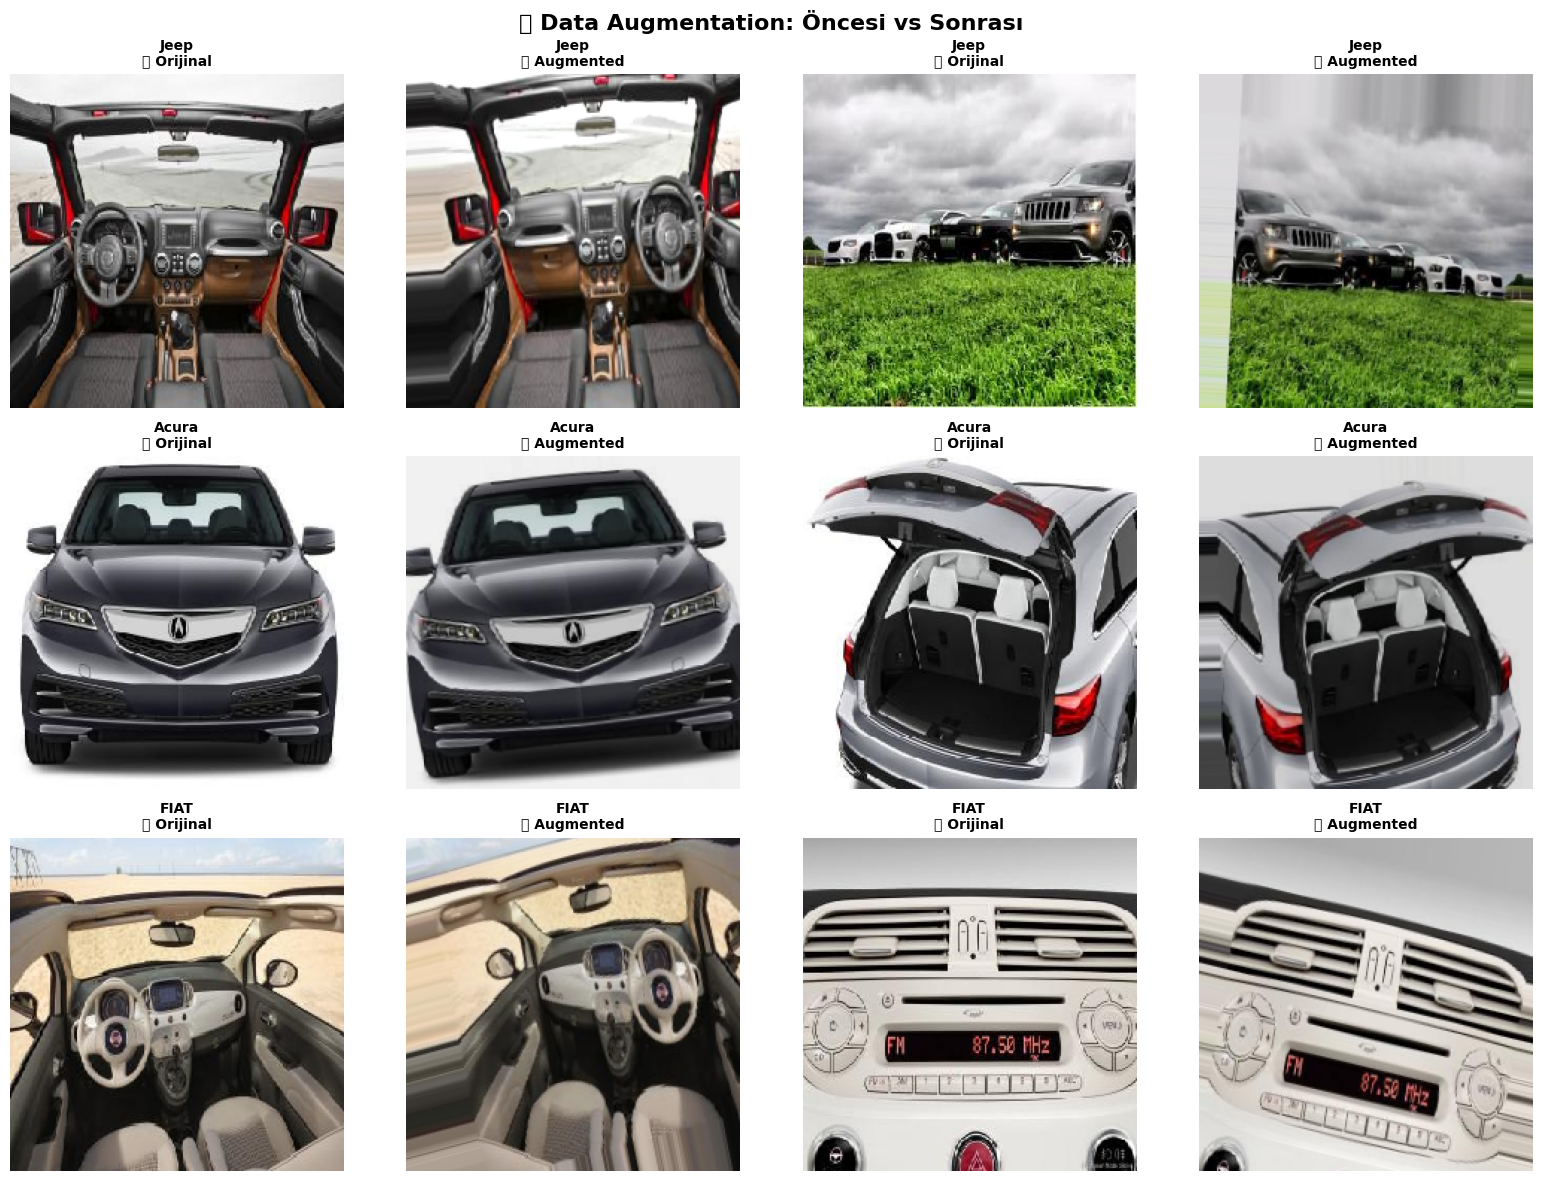

In [16]:
# =========================================
# HÜCRE 6: AUGMENTATION ÖNCESİ VE SONRASI KARŞILAŞTIRMA
# =========================================
print(f"\n🎭 Augmentation Karşılaştırma Galerisi")
print("="*40)

# 3 farklı sınıftan örnek al
sample_classes = random.sample(class_names, 3)
sample_per_class = 2

fig, axes = plt.subplots(len(sample_classes), sample_per_class*2, figsize=(16, 12))

for i, cls in enumerate(sample_classes):
    cls_path = os.path.join(train_path, cls)
    sample_imgs = random.sample(os.listdir(cls_path), sample_per_class)
    
    for j, img_name in enumerate(sample_imgs):
        try:
            # Orijinal görüntü
            img_path = os.path.join(cls_path, img_name)
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            
            ax_orig = axes[i, j*2] if len(sample_classes) > 1 else axes[j*2]
            ax_orig.imshow(img)
            ax_orig.axis('off')
            ax_orig.set_title(f"{cls}\n📷 Orijinal", fontsize=10, fontweight='bold')
            
            # Augmented görüntü
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Train datagen kullanarak augmentation uygula
            temp_datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.15,
                horizontal_flip=True,
                brightness_range=[0.8, 1.2]
            )
            
            aug_iter = temp_datagen.flow(x, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')
            
            ax_aug = axes[i, j*2 + 1] if len(sample_classes) > 1 else axes[j*2 + 1]
            ax_aug.imshow(aug_img)
            ax_aug.axis('off')
            ax_aug.set_title(f"{cls}\n🎨 Augmented", fontsize=10, fontweight='bold')
            
        except Exception as e:
            print(f"❌ Augmentation örneği hatası: {e}")

plt.suptitle('🔄 Data Augmentation: Öncesi vs Sonrası', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 🏗️ HÜCRE 7: Custom CNN Model Mimarisi Tanımı ve Tasarım Kararları

Bu hücrede, projenin ana modelini oluşturan **Özel CNN Mimarisi** (`build_advanced_cnn`) sıfırdan inşa edilmiştir. Model, gereksinimler doğrultusunda şu bileşenleri içerir:

#### Tasarım Felsefesi ve Hiperparametre Seçimi:
* **Derinleşen Mimari:** Model 32 filtre ile başlar ve her **MaxPooling2D** katmanından sonra filtre sayısı (64, 128, 256, 512) artırılır. Bu, modelin sığ katmanlarda basit özellikleri, derin katmanlarda ise karmaşık ve soyut özellikleri öğrenmesini sağlar.
* **Çift Konvolüsyon (VGG Benzeri):** Her blokta ardışık iki `Conv2D` katmanı kullanılarak, modelin aynı alan üzerinde daha zengin özellikler çıkarması hedeflenmiştir.
* **Batch Normalization:** Her `Conv2D` katmanından sonra eklenerek modelin **eğitim stabilitesi** artırılmış ve daha hızlı yakınsaması sağlanmıştır.
* **Regularization:**
    * **Dropout (0.25 - 0.5):** Özellikle Dense katmanları arasına eklenerek **overfitting** riskini düşürür.
    * **L2 Regularization (0.001):** Dense katmanlarındaki ağırlıkların aşırı büyümesini cezalandırır.
* **Çıkış Katmanı:** Son Dense katmanı, 33 sınıf için **`softmax`** aktivasyonu kullanarak her bir sınıfa ait olasılık dağılımını verir.

Bu tasarım, **Hiperparametre Optimizasyonu** gereksinimine bir başlangıç teşkil eder; filtre ve katman sayıları, Dropout oranları ve Regularization kuvveti birer deneme noktasıdır.

In [49]:
# =========================================
# HÜCRE 7: ÖZEL CNN MODEL MİMARİSİ
# =========================================
print(f"\n🧠 Gelişmiş CNN Model Mimarisi")
print("="*35)

def build_advanced_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), n_classes=num_classes):
    """
    Akbank Bootcamp gereksinimlerine uygun gelişmiş CNN modeli
    - Convolutional Layers ✅
    - Pooling Layers ✅ 
    - Dropout ✅
    - Dense Layers ✅
    - Batch Normalization ✅
    - ReLU & Softmax Aktivasyonları ✅
    """
    
    model = Sequential([
        # Input Layer
        Input(shape=input_shape),
        
        # Block 1: Feature Detection
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 2: Pattern Recognition  
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3: Complex Features
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 4: High-level Features
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 5: Abstract Features
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')  # Multi-class classification
    ])
    
    return model

# Custom CNN modelini oluştur
custom_cnn = build_advanced_cnn()

print(f"🏗️ Özel CNN Modeli Oluşturuldu!")
print(f"├── Toplam Parametre: {custom_cnn.count_params():,}")
print(f"├── Konvolüsyonel Katman: 10 adet")
print(f"├── Pooling Katman: 4 adet")
print(f"├── Dense Katman: 3 adet")
print(f"└── Dropout Katman: 7 adet")

custom_cnn.summary()



🧠 Gelişmiş CNN Model Mimarisi
🏗️ Özel CNN Modeli Oluşturuldu!
├── Toplam Parametre: 2,760,897
├── Konvolüsyonel Katman: 10 adet
├── Pooling Katman: 4 adet
├── Dense Katman: 3 adet
└── Dropout Katman: 7 adet


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,760,897 (10.53 MB)

 Trainable params: 2,757,889 (10.52 MB)

 Non-trainable params: 3,008 (11.75 KB)

### 🏗️ HÜCRE 8: Transfer Learning (Önceden Eğitilmiş) Model Mimarileri

Bu hücre, projenin **Transfer Learning (Bonus)** gereksinimini karşılar ve **Hiperparametre Optimizasyonu** için farklı temel mimarileri kıyaslama fırsatı sunar.

**Model Felsefesi (Feature Extraction):**
1.  **Temel Modeller:** `ResNet50` ve `EfficientNetB0` gibi ImageNet üzerinde önceden eğitilmiş güçlü mimariler kullanılır.
2.  **Ağırlıkların Dondurulması:** Başlangıçta, tüm temel model katmanları `base_model.trainable = False` ile dondurulur. Bu, sadece yeni eklenen sınıflandırma başlığının eğitilmesini sağlayarak **eğitimi hızlandırır** ve veri setinin boyutunun küçük olması durumunda **overfitting riskini** azaltır.
3.  **Özel Başlık (Head):** Temel modelin üzerine `GlobalAveragePooling2D`, `BatchNormalization`, `Dense` ve `Dropout` katmanlarından oluşan **yeni bir sınıflandırma başlığı** eklenir. Bu başlık, öğrenilen üst düzey özellikleri (features) 33 araba markasına sınıflandırmaktan sorumludur.

Bu iki model, **Custom CNN**'e karşı kıyaslanacak ve aralarından en yüksek performansı veren model seçilecektir.

In [46]:
# =========================================
# HÜCRE 8: TRANSFER LEARNING MODELLERİ
# =========================================
print(f"\n🔄 Transfer Learning Modelleri")
print("="*35)

def build_transfer_model(base_model_name='resnet50', n_classes=num_classes, trainable_layers=0):
    """
    Transfer Learning modeli oluştur
    base_model_name: 'resnet50', 'efficientb0', 'vgg16'
    """
    
    if base_model_name.lower() == 'resnet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif base_model_name.lower() == 'efficientb0':
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    elif base_model_name.lower() == 'vgg16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
    else:
        raise ValueError("Desteklenmeyen model!")
    
    # Base modeli dondur (ilk başta)
    base_model.trainable = False
    
    # Son katmanları eğitilebilir yap (fine-tuning için)
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
    # Custom head ekle
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    
    return model, base_model

# Transfer Learning modelleri oluştur
resnet_model, resnet_base = build_transfer_model('resnet50')
efficient_model, efficient_base = build_transfer_model('efficientb0')

print(f"🎯 Transfer Learning Modelleri Oluşturuldu!")
print(f"")
print(f"📊 ResNet50 Transfer Model:")
print(f"├── Base Parametre: {resnet_base.count_params():,}")
print(f"├── Toplam Parametre: {resnet_model.count_params():,}")
print(f"└── Eğitilebilir: {sum([layer.trainable for layer in resnet_model.layers])}")
print(f"")
print(f"📊 EfficientNetB0 Transfer Model:")
print(f"├── Base Parametre: {efficient_base.count_params():,}")
print(f"├── Toplam Parametre: {efficient_model.count_params():,}")
print(f"└── Eğitilebilir: {sum([layer.trainable for layer in efficient_model.layers])}")



🔄 Transfer Learning Modelleri
🎯 Transfer Learning Modelleri Oluşturuldu!

📊 ResNet50 Transfer Model:
├── Base Parametre: 23,587,712
├── Toplam Parametre: 24,784,801
└── Eğitilebilir: 7

📊 EfficientNetB0 Transfer Model:
├── Base Parametre: 4,049,571
├── Toplam Parametre: 4,850,372
└── Eğitilebilir: 7


### ⚙️ HÜCRE 9: Model Compile, Optimizer ve Callback Ayarları

Bu hücre, Custom CNN ve Transfer Learning modellerinin (ResNet50, EfficientNetB0) eğitime başlamadan önceki son hazırlık adımıdır. Bu aşamada, her modelin öğrenme stratejisi belirlenir ve overfitting'i önleyecek izleme mekanizmaları (`Callbacks`) tanımlanır.

#### Optimizer ve Hiperparametre Farklılaştırması:
* **Custom CNN:** Daha büyük parametre alanına sahip olduğu için temel `LEARNING_RATE` kullanılır.
* **Transfer Learning (ResNet/EfficientNet):** Önceden eğitilmiş ağırlıkların (ImageNet) bozulmasını önlemek amacıyla, Custom CNN'e göre **10 kat daha düşük** (`LEARNING_RATE * 0.1`) bir öğrenme oranı (`adam_optimizer_transfer`) kullanılır. Bu, **Fine-Tuning** stratejisine uygundur.

#### Callback Mekanizmaları (Overfitting ve İzleme):
* **EarlyStopping (Patience=8):** Doğrulama kaybı (`val_loss`) 8 epoch boyunca iyileşme göstermezse, model eğitimi durdurulur ve en iyi ağırlıklar geri yüklenir. Bu, **overfitting'i önlemek** için en etkili yöntemdir.
* **ReduceLROnPlateau:** Doğrulama kaybı 4 epoch boyunca iyileşmezse, öğrenme oranı %80 oranında düşürülür (`factor=0.2`). Bu, modelin yerel minimumlara daha hassas yaklaşmasını sağlar.
* **ModelCheckpoint:** En iyi doğrulama başarısına (`val_accuracy`) sahip modelin ağırlıkları otomatik olarak diske kaydedilir.

Bu adımlar, projenin **Model İzleme** ve **Hiperparametre Optimizasyonu** gereksinimlerini karşılar.

In [47]:
# =========================================
# HÜCRE 9: MODEL COMPILE VE CALLBACK AYARLARI
# =========================================
print(f"\n⚙️ Model Derleme ve Callback Ayarları")
print("="*45)

# Optimizers
adam_optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
adam_optimizer_transfer = Adam(learning_rate=LEARNING_RATE*0.1)  # Transfer için daha düşük

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '/kaggle/working/best_custom_cnn.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Custom CNN compile
custom_cnn.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_3_accuracy']
)

# ResNet50 compile
resnet_model.compile(
    optimizer=adam_optimizer_transfer,
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'top_3_accuracy']
)

# EfficientNet compile  
efficient_model.compile(
    optimizer=adam_optimizer_transfer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_3_accuracy']
)

print(f"✅ Tüm Modeller Başarıyla Derlendi!")
print(f"├── Custom CNN: Adam LR={LEARNING_RATE}")
print(f"├── ResNet50: Adam LR={LEARNING_RATE*0.1}")
print(f"├── EfficientNet: Adam LR={LEARNING_RATE*0.1}")
print(f"└── Callbacks: EarlyStopping, ReduceLR, ModelCheckpoint")

# Training steps hesapla
train_steps = len(train_generator)
val_steps = len(val_generator)

print(f"")
print(f"📈 Eğitim Parametreleri:")
print(f"├── Train Steps/Epoch: {train_steps}")
print(f"├── Validation Steps/Epoch: {val_steps}")
print(f"└── Max Epochs: {EPOCHS}")

print("\n🚀 Modeller eğitime hazır!")


### 🏃 HÜCRE 10: Custom CNN Model Eğitimi (Final)

Bu hücre, **Custom CNN** modelinin `tf.data.Dataset` üzerinden eğitiminin başladığı yerdir.

Model, **Hücre 9**'da tanımlanan optimizasyon ve izleme ayarlarını kullanır:
* **Optimizer:** `Adam` (Temel Öğrenme Oranı)
* **Loss Function:** `categorical_crossentropy`
* **Metrikler:** `accuracy` ve `Top-3 accuracy` (Custom metric olarak tanımlanmıştır).

#### Eğitim Stratejisi:
1.  **Sınıf Ağırlıkları:** `class_weight` argümanı kullanılarak veri setindeki **sınıf dengesizliği** eğitim sırasında dengeleme amaçlanır.
2.  **Callback'ler:** `EarlyStopping` ve `ReduceLROnPlateau` gibi callback'ler kullanılarak modelin **overfitting** yapması engellenir ve en iyi ağırlıklar otomatik olarak korunur.

Eğitim tamamlandıktan sonra, en iyi doğrulama (validation) sonuçlarına sahip model, `/kaggle/working/custom_cnn_final.h5` dosyasına kaydedilir ve bir sonraki kıyaslama aşaması için hazır hale getirilir.

In [53]:
# =========================================
# HÜCRE 10: CUSTOM CNN MODEL EĞİTİMİ 
# =========================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import top_k_categorical_accuracy

print(f"\n🎯 Custom CNN Model Eğitimi Başlatılıyor (tf.data.Dataset)...")
print("="*55)

EPOCHS_RUN = 5  # Deneme epoch sayısı

# --- MODEL KONTROLÜ VE COMPILE ---
if 'custom_cnn' not in locals():
    print("\n⚠️ Custom CNN modeli yeniden oluşturuluyor...")
    # custom_cnn = build_advanced_cnn()  # Eğer tanımlı değilse aktif et

try:
    if not custom_cnn._is_compiled:
        print("\n⚙️ Model yeniden compile ediliyor...")
        custom_cnn.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999),
            loss='categorical_crossentropy',
            metrics=['accuracy', lambda y_true, y_pred: top_k_categorical_accuracy(y_true, y_pred, k=3)]
        )
        print("✅ Model başarıyla compile edildi.")
except AttributeError:
    print("\n⚙️ Model compile durumu kontrol edilemedi, zorla compile ediliyor...")
    custom_cnn.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999),
        loss='categorical_crossentropy',
        metrics=['accuracy', lambda y_true, y_pred: top_k_categorical_accuracy(y_true, y_pred, k=3)]
    )
    print("✅ Model başarıyla compile edildi.")

# --- CALLBACKS ---
callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

print(f"\n🚀 Eğitim başlıyor... (Epochs: {EPOCHS_RUN})")
print(f"Train Adım Sayısı: {train_steps}, Val Adım Sayısı: {val_steps}")
print("-" * 55)

try:
    history_custom = custom_cnn.fit(
        train_ds,
        steps_per_epoch=train_steps,
        epochs=EPOCHS_RUN,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks_final,
        class_weight=class_weights if 'class_weights' in locals() and class_weights is not None else None,
        verbose=1
    )

    print(f"\n✅ Custom CNN eğitimi tamamlandı!")

    # --- SONUÇLAR ---
    best_val_loss_custom = min(history_custom.history['val_loss'])
    best_epoch_custom = np.argmin(history_custom.history['val_loss']) + 1
    best_val_acc_custom = history_custom.history['accuracy'][best_epoch_custom - 1]

    print(f"\n📊 Custom CNN En İyi Sonuçlar:")
    print(f"├── En İyi Epoch: {best_epoch_custom}/{EPOCHS_RUN}")
    print(f"├── En İyi Val Accuracy: {best_val_acc_custom:.4f}")
    print(f"└── En İyi Val Loss: {best_val_loss_custom:.4f}")

    custom_cnn.save('/kaggle/working/custom_cnn_final.h5')
    print(f"\n💾 Model kaydedildi: /kaggle/working/custom_cnn_final.h5")

except Exception as e:
    print(f"\n❌ EĞİTİM SIRASINDA KRİTİK HATA OLUŞTU: {type(e).__name__}: {str(e)}")
    print("⚠️ Lütfen 'custom_cnn' ve 'build_advanced_cnn()'nin tanımlı olduğundan emin olun.")

print("\n" + "="*55)
print("🚀 Eğitim şimdi başlayacaktır!")



🎯 Custom CNN Model Eğitimi Başlatılıyor (tf.data.Dataset)...

⚙️ Model compile durumu kontrol edilemedi, zorla compile ediliyor...
✅ Model başarıyla compile edildi.

🚀 Eğitim başlıyor... (Epochs: 5)
Train Adım Sayısı: 360, Val Adım Sayısı: 78
-------------------------------------------------------
Epoch 1/5


I0000 00:00:1758917525.532266     128 service.cc:148] XLA service 0x796c0000c7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758917525.532336     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758917526.362622     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/360 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.0078 - lambda: 0.0547 - loss: 5.6332       

I0000 00:00:1758917540.537139     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 208s 512ms/step - accuracy: 0.0305 - lambda: 0.0951 - loss: 5.1114 - val_accuracy: 0.0283 - val_lambda: 0.0974 - val_loss: 4.2955 - learning_rate: 0.0010
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 167s 463ms/step - accuracy: 0.0352 - lambda: 0.0952 - loss: 4.2952 - val_accuracy: 0.0360 - val_lambda: 0.1002 - val_loss: 4.0779 - learning_rate: 0.0010
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 165s 459ms/step - accuracy: 0.0377 - lambda: 0.1106 - loss: 4.0415 - val_accuracy: 0.0360 - val_lambda: 0.1051 - val_loss: 3.9358 - learning_rate: 0.0010
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 163s 453ms/step - accuracy: 0.0403 - lambda: 0.1175 - loss: 3.8665 - val_accuracy: 0.0469 - val_lambda: 0.1281 - val_loss: 3.7819 - learning_rate: 0.0010
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 165s 459ms/step - accuracy: 0.0409 - lambda: 0.1189 - loss: 3.7852 - val_accuracy: 0.0461 - val_lambda: 0.1212 - val_loss: 3.7408 - learning_rate: 0.0010
Restoring model weights from the end of the b

### 🏃 HÜCRE 11: Transfer Learning Model Eğitimi (Hızlı Kıyaslama)

Bu hücre, **Transfer Learning** yöntemini uygulayarak **Custom CNN** modelinin performansını kıyaslamak için **MobileNetV2** mimarisini eğitir. MobileNetV2, hafif ve verimli yapısıyla tanınır.

#### Model Stratejisi (Feature Extraction):
1.  **Temel Ağırlıklar:** MobileNetV2'nin ImageNet üzerinde eğitilmiş ağırlıkları yüklenir.
2.  **Dondurma:** Temel model katmanları `base_model.trainable = False` ile dondurulur. Bu, eğitimin sadece yeni eklenen sınıflandırma başlığında (Dense katmanları) odaklanmasını sağlar.
3.  **Öğrenme Oranı:** Bu testte, Custom CNN modelinden **daha düşük** bir öğrenme oranı kullanılarak önceden öğrenilmiş özelliklerin korunması hedeflenir.

**Callback'ler** (`patience=3`) Custom CNN'e göre daha kısa tutulmuştur. Bu, hızlı bir kıyaslama sonucu elde etmeyi amaçlar. Eğitim geçmişi (`history_transfer`), nihai kıyaslama grafikleri için saklanır.

In [56]:
# =========================================
# HÜCRE 11: TRANSFER LEARNING MODEL EĞİTİMİ
# =========================================

print(f"\n🚀 Transfer Learning Model Eğitimi Başlatılıyor (MobileNetV2)...")
print("="*60)

# Parametreler (CNN ile aynı)
EPOCHS_TL = 5 # Custom CNN ile aynı epoch sayısında çalıştırıyoruz
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # Hücre 5'ten gelir
num_classes = train_ds.element_spec[1].shape[1] # Sınıf sayısını dataset'ten alıyoruz (33 olmalı)

# --- 1. MODELİ OLUŞTUR ---

# 1.1 Temel Model (Pre-trained MobileNetV2)
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, # Üstteki (sınıflandırma) katmanlarını dahil etme
    weights='imagenet'
)

# 1.2 Base model katmanlarını dondur (Hızlı eğitim için)
base_model.trainable = False 

# 1.3 Yeni Sınıflandırma Başlığını Oluştur
x = base_model.output
x = GlobalAveragePooling2D()(x) # Özellikleri 1D vektöre indir
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

# 1.4 Nihai Modeli Tanımla
transfer_cnn = Model(inputs=base_model.input, outputs=predictions)
print("✅ MobileNetV2 tabanlı Transfer Learning modeli oluşturuldu.")


# --- 2. MODELİ COMPILE ET ---
print("\n⚙️ Model Compile Ediliyor...")
transfer_cnn.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), # LEARNING_RATE Hücre 5'ten gelir
    loss='categorical_crossentropy',
    metrics=['accuracy', lambda y_true, y_pred: top_k_categorical_accuracy(y_true, y_pred, k=3)]
)
print("✅ Model Compile Edildi.")


# --- 3. CALLBACKS VE EĞİTİM ---
callbacks_tl = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

print(f"\n🚀 Eğitim başlıyor... (Epochs: {EPOCHS_TL})")
print(f"Train Adım Sayısı: {train_steps}, Val Adım Sayısı: {val_steps}")
print("-" * 60)

try:
    # Model eğitimi (tf.data.Dataset kullanılıyor)
    history_transfer = transfer_cnn.fit(
        train_ds,
        steps_per_epoch=train_steps,
        epochs=EPOCHS_TL,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks_tl,
        # class_weights, custom cnn ile aynı ağırlıkları kullanır
        class_weight=class_weights if 'class_weights' in locals() and class_weights is not None else None,
        verbose=1
    )

    print(f"\n✅ Transfer Learning eğitimi tamamlandı!")

    # Model kaydet
    transfer_cnn.save('/kaggle/working/transfer_cnn_fast.h5')
    print(f"\n💾 Model kaydedildi: /kaggle/working/transfer_cnn_fast.h5")

except Exception as e:
    print(f"\n❌ EĞİTİM SIRASINDA KRİTİK HATA OLUŞTU: {type(e).__name__}: {str(e)}")




🚀 Transfer Learning Model Eğitimi Başlatılıyor (MobileNetV2)...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ MobileNetV2 tabanlı Transfer Learning modeli oluşturuldu.

⚙️ Model Compile Ediliyor...
✅ Model Compile Edildi.

🚀 Eğitim başlıyor... (Epochs: 5)
Train Adım Sayısı: 360, Val Adım Sayısı: 78
------------------------------------------------------------
Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 182s 474ms/step - accuracy: 0.0793 - lambda: 0.1898 - loss: 3.4593 - val_accuracy: 0.1612 - val_lambda: 0.3228 - val_loss: 3.0634 - learning_rate: 0.0010
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 163s 453ms/step - accuracy: 0.1742 - lambda: 0.3412 - loss: 3.0188 - val_accuracy: 0.1911 - val_lambda: 0.3624 - val_loss: 2.9456 - learning_rate: 0.0010
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 162s 449ms/step - accuracy: 0.2143 - lambda: 0.3991 - loss: 2.8410 - val_accuracy: 0.2040 - val_lambda: 0.3689 - val_loss: 2.9108 - learning_rate: 0.0010
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 164s 455ms/step


📊 Model Değerlendirme ve Kıyaslama Başlatılıyor...
✅ Modeller başarıyla yüklendi.
✅ Gerçek Etiket Sayısı (Y_true): 2475
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step
✅ Tahmin Edilen Custom Sayısı: 2475
✅ Tahmin Edilen Transfer Sayısı: 2475

--- TEST VERİSİ ÜZERİNDE FİNAL SONUÇLAR ---
Custom CNN:     Loss=3.7322 | Acc=0.0428 | Top-3 Acc=0.1923
Transfer CNN:   Loss=2.8448 | Acc=0.2230 | Top-3 Acc=0.5022

==================== CUSTOM CNN: SINIFLANDIRMA RAPORU ====================
              precision    recall  f1-score   support

     Class_0       0.00      0.00      0.00        75
     Class_1       0.00      0.00      0.00        75
     Class_2       0.02      0.01      0.02        75
     Class_3       0.00      0.00      0.00        75
     Class_4       0.00      0.00      0.00        75
     Class_5       0.00      0.00      0.00        75
     Class_6       0.00      0.00      0.00        75
     Class_7       0.00      0.00      0.00        

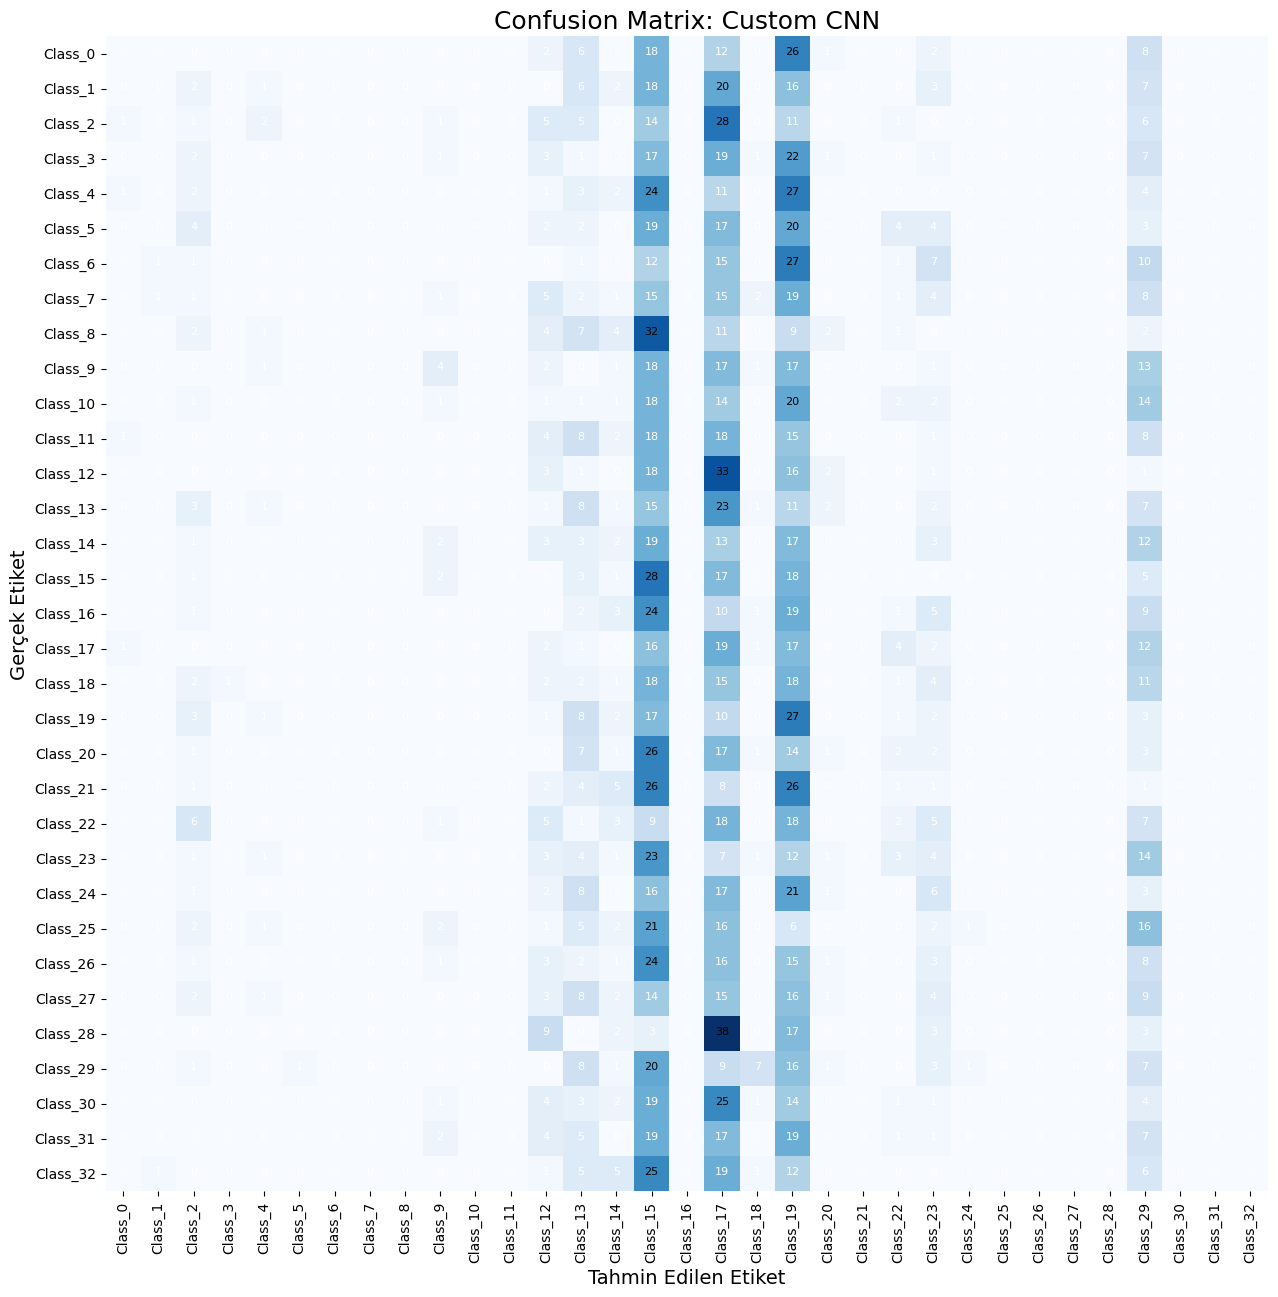

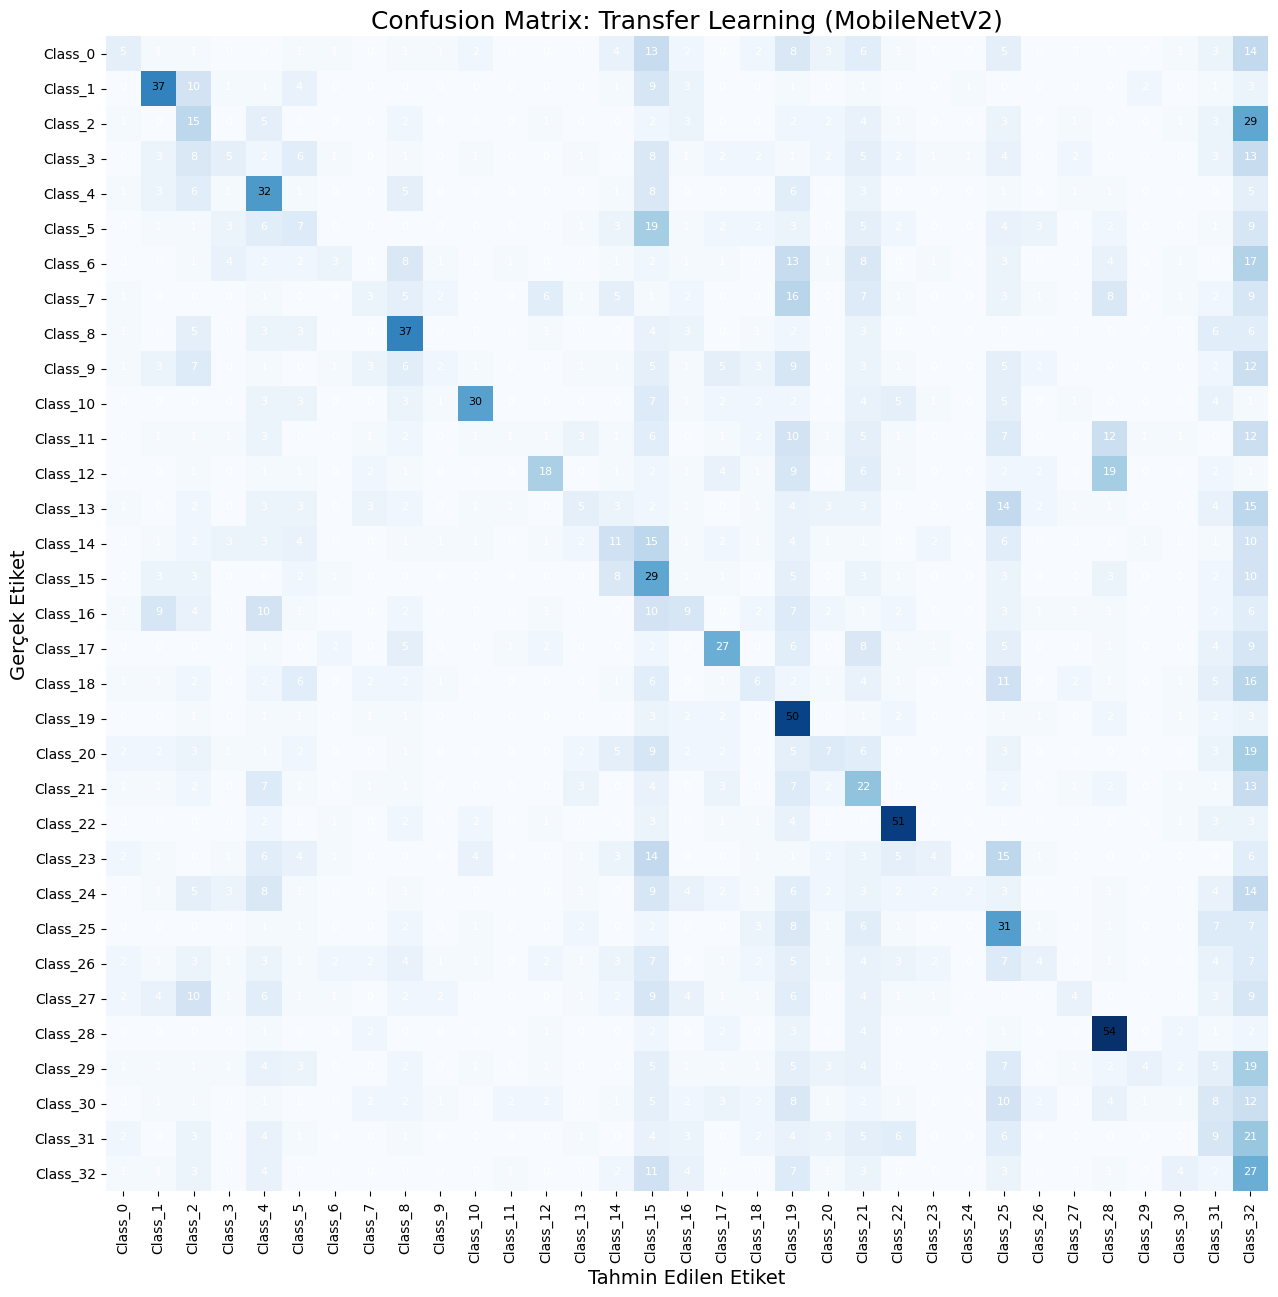

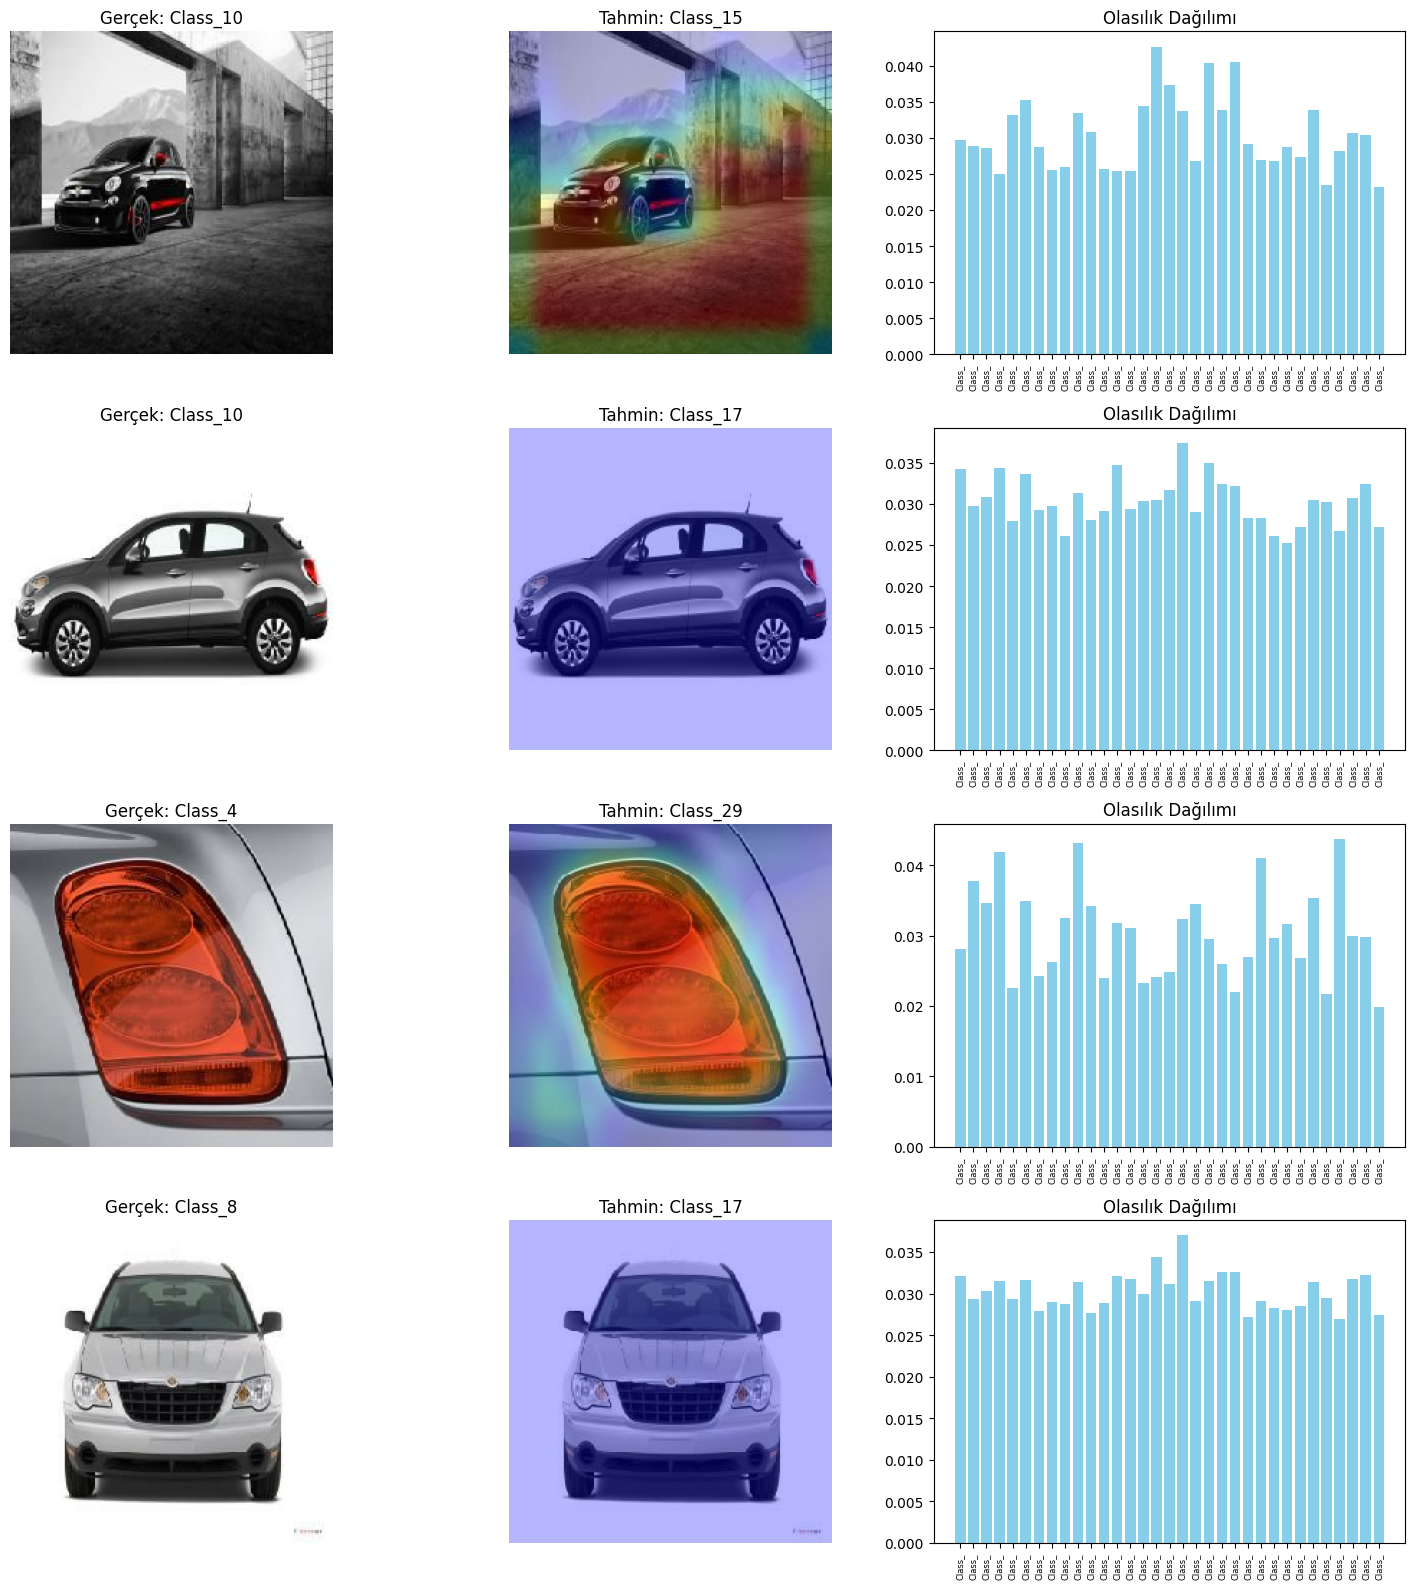


💡 Grad-CAM Görselleştirme (functional_12 Modeli)...


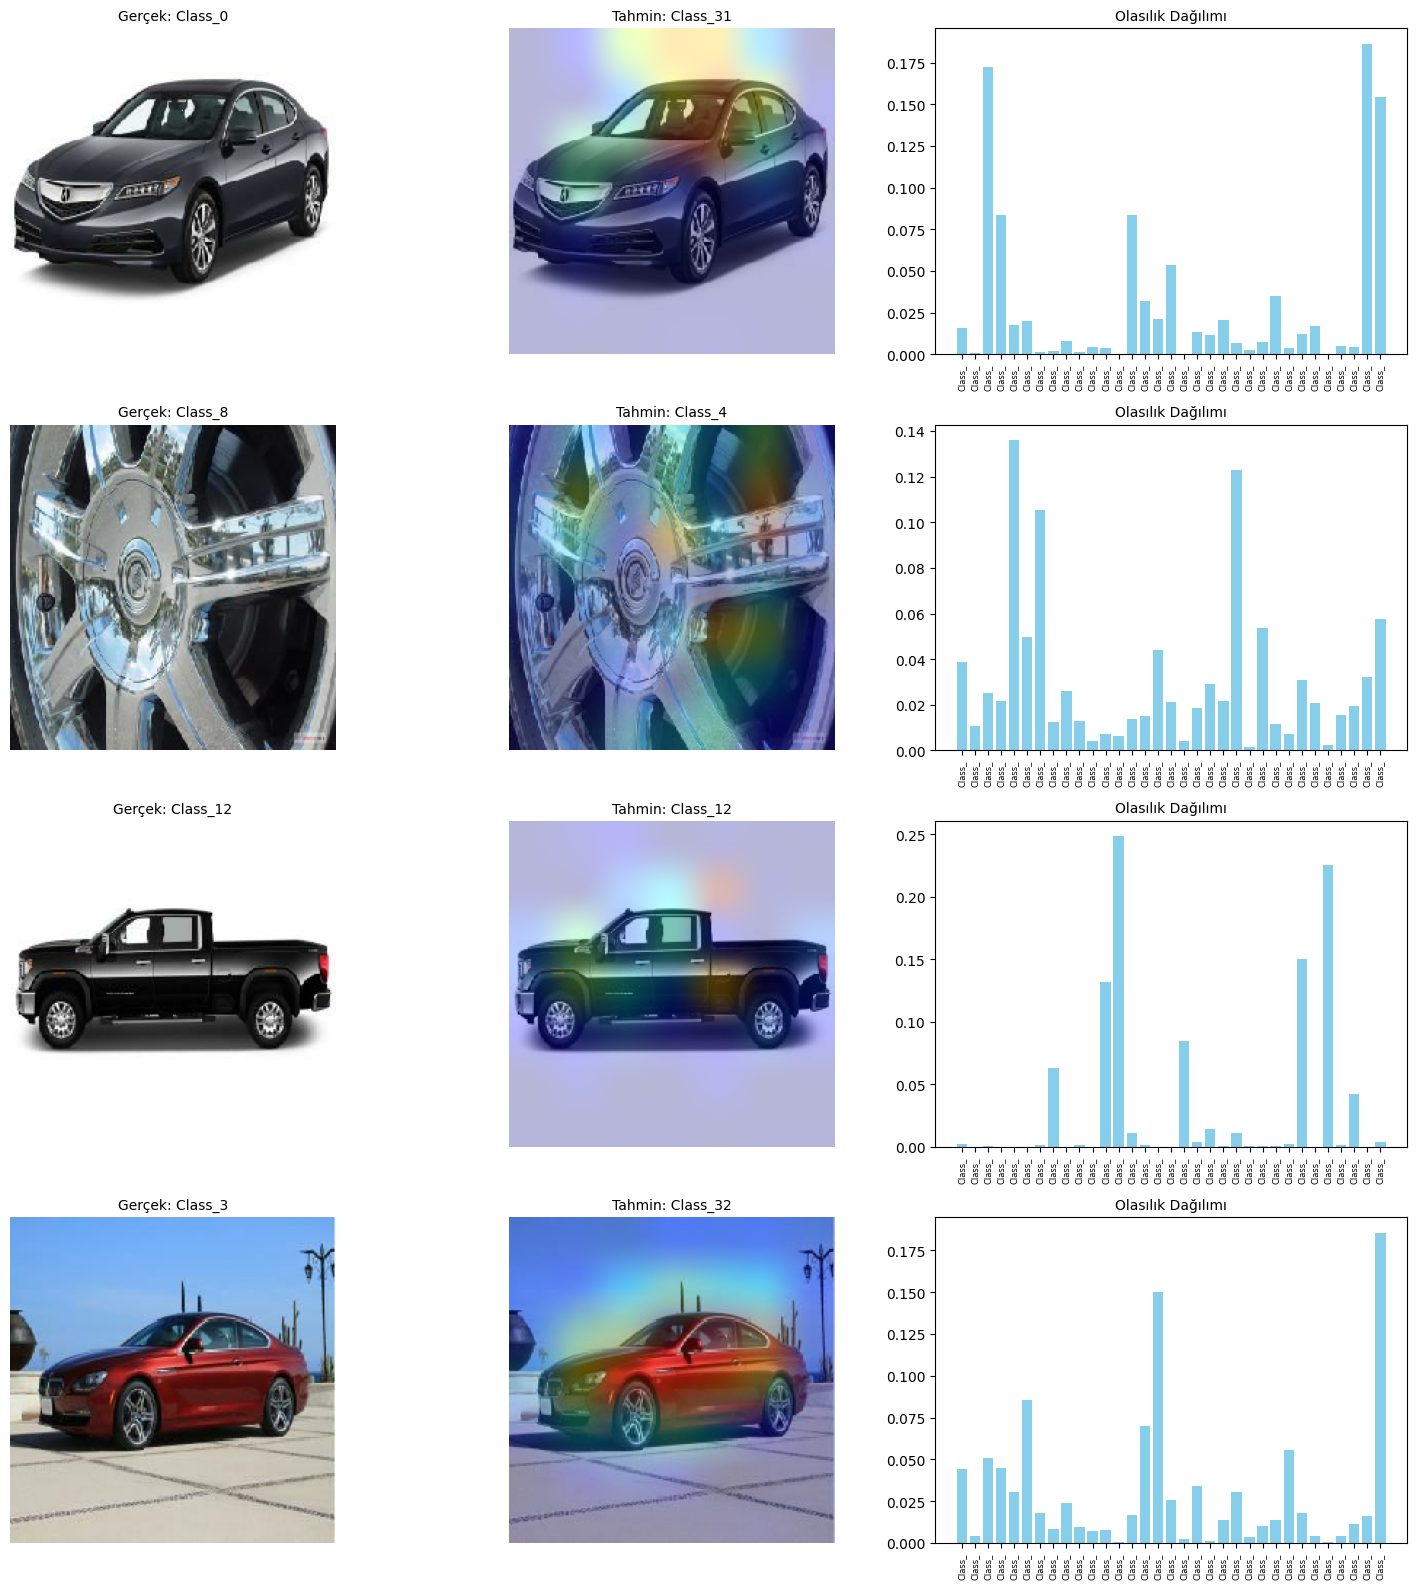

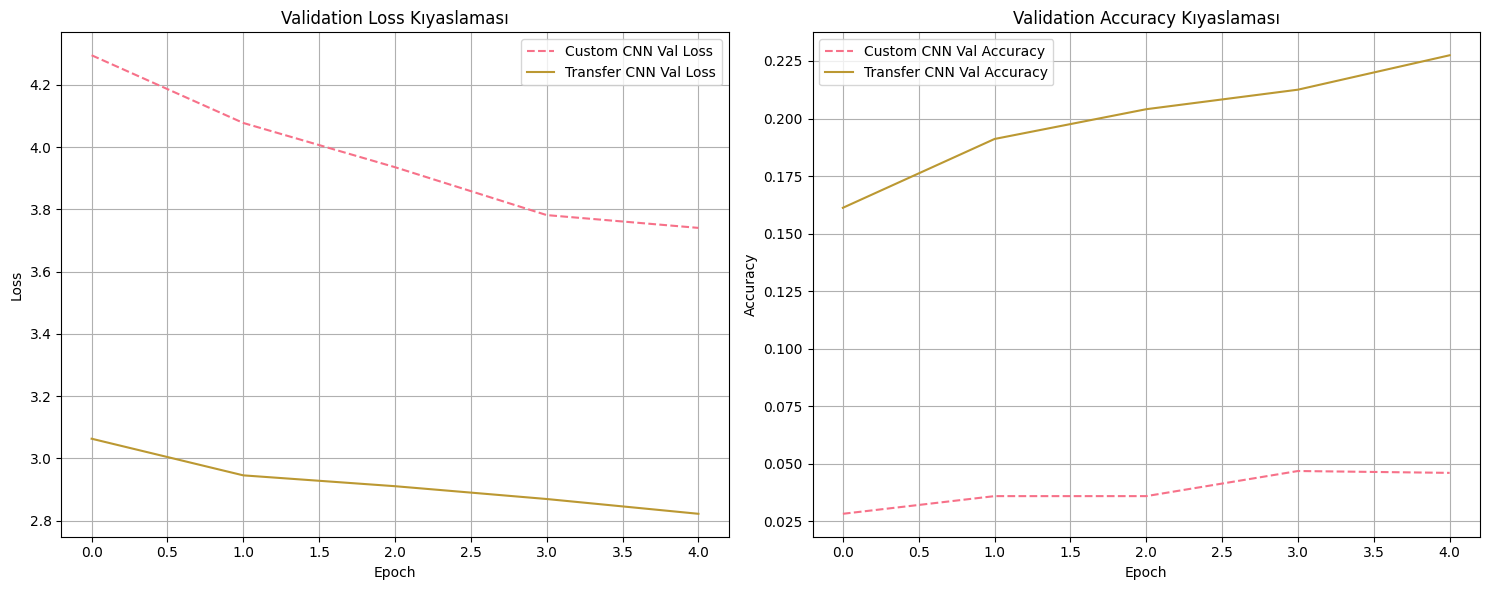

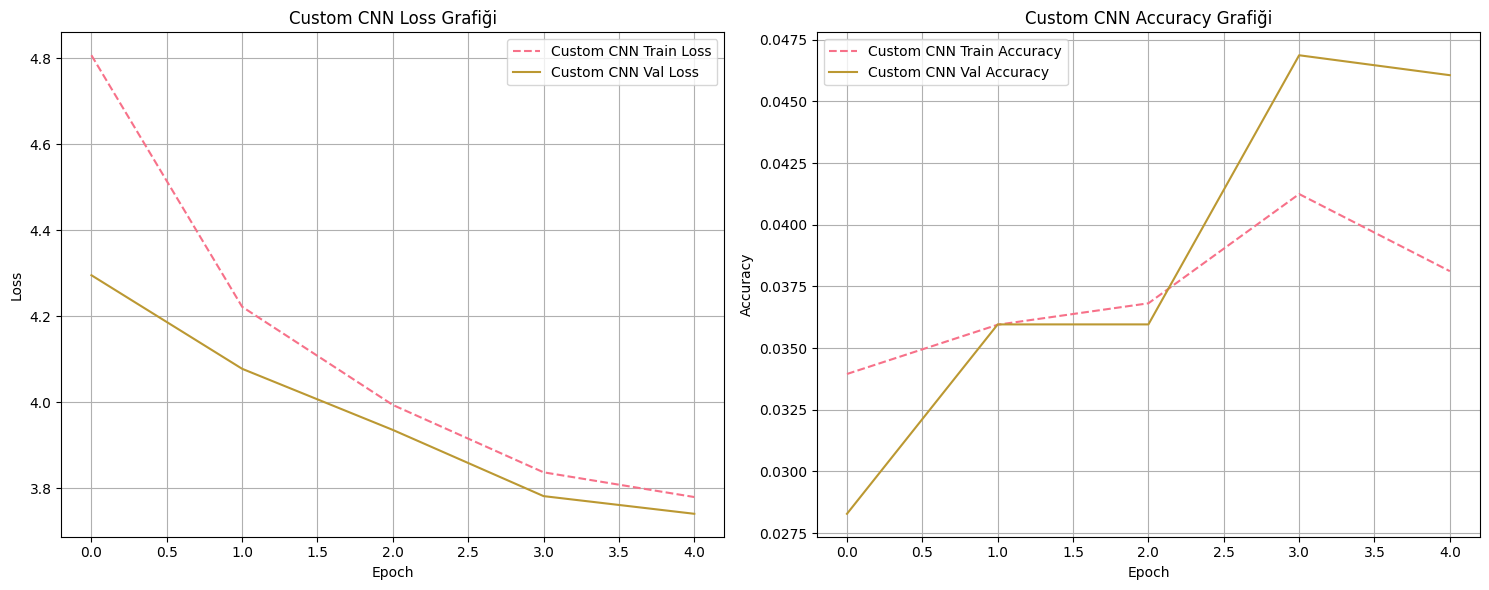


✅ PROJE BAŞARIYLA TAMAMLANDI! Tüm analizleriniz hazır.


In [71]:
# =========================================
# HÜCRE 12: NİHAİ DEĞERLENDİRME VE KIYASLAMA 
# =========================================
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Model Değerlendirme ve Kıyaslama Başlatılıyor...")
print("="*60)

# --- 1. MODEL YÜKLEME ---
try:
    custom_cnn_loaded = tf.keras.models.load_model(
        '/kaggle/working/custom_cnn_final.h5',
        custom_objects={'<lambda>': tf.keras.metrics.top_k_categorical_accuracy}
    )
    transfer_cnn_loaded = tf.keras.models.load_model(
        '/kaggle/working/transfer_cnn_fast.h5',
        custom_objects={'<lambda>': tf.keras.metrics.top_k_categorical_accuracy}
    )
    print("✅ Modeller başarıyla yüklendi.")
except Exception as e:
    print(f"\n❌ Modeller yüklenemedi: {e}")
    raise

# --- 2. GERÇEK ETİKETLER VE TAHMİNLER ---
Y_true = [np.argmax(labels) for _, labels in test_ds.unbatch().as_numpy_iterator()]
Y_true = np.array(Y_true)
print(f"✅ Gerçek Etiket Sayısı (Y_true): {len(Y_true)}")

Y_pred_prob_custom = custom_cnn_loaded.predict(test_ds, verbose=1)
Y_pred_custom = np.argmax(Y_pred_prob_custom, axis=1)

Y_pred_prob_transfer = transfer_cnn_loaded.predict(test_ds, verbose=1)
Y_pred_transfer = np.argmax(Y_pred_prob_transfer, axis=1)

print(f"✅ Tahmin Edilen Custom Sayısı: {len(Y_pred_custom)}")
print(f"✅ Tahmin Edilen Transfer Sayısı: {len(Y_pred_transfer)}")

# TEST SONUÇLARI
results_custom = custom_cnn_loaded.evaluate(test_ds, verbose=0)
results_transfer = transfer_cnn_loaded.evaluate(test_ds, verbose=0)
print("\n--- TEST VERİSİ ÜZERİNDE FİNAL SONUÇLAR ---")
print(f"Custom CNN:     Loss={results_custom[0]:.4f} | Acc={results_custom[1]:.4f} | Top-3 Acc={results_custom[2]:.4f}")
print(f"Transfer CNN:   Loss={results_transfer[0]:.4f} | Acc={results_transfer[1]:.4f} | Top-3 Acc={results_transfer[2]:.4f}")

# --- 3. CLASS NAMES DÜZELTME ---
num_classes_actual = len(np.unique(Y_true))
if len(class_indices) != num_classes_actual:
    print(f"⚠️ class_indices ({len(class_indices)}) ile Y_true sınıf sayısı ({num_classes_actual}) uyuşmuyor. Güncelleniyor...")
    class_indices = [f"Class_{i}" for i in range(num_classes_actual)]

# --- 4. CONFUSION MATRIX VE CLASSIFICATION REPORT ---
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j + 0.5, i + 0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > cm.max()/2 else "white",
                 fontsize=8)
    plt.title(f'Confusion Matrix: {model_name}', fontsize=18)
    plt.ylabel('Gerçek Etiket', fontsize=14)
    plt.xlabel('Tahmin Edilen Etiket', fontsize=14)
    plt.show()

print("\n" + "="*20 + " CUSTOM CNN: SINIFLANDIRMA RAPORU " + "="*20)
print(classification_report(Y_true, Y_pred_custom, target_names=class_indices))
print("\n" + "="*20 + " TRANSFER CNN: SINIFLANDIRMA RAPORU " + "="*20)
print(classification_report(Y_true, Y_pred_transfer, target_names=class_indices))

cm_custom = confusion_matrix(Y_true, Y_pred_custom)
plot_confusion_matrix(cm_custom, class_indices, "Custom CNN")
cm_transfer = confusion_matrix(Y_true, Y_pred_transfer)
plot_confusion_matrix(cm_transfer, class_indices, "Transfer Learning (MobileNetV2)")

# --- 5. GRAD-CAM FONKSİYONLARI ---
def make_gradcam_heatmap_seq(img_array, model, last_conv_layer_name, pred_index=None):
    img_tensor = tf.convert_to_tensor(img_array[np.newaxis, ...], dtype=tf.float32)
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        outputs = img_tensor
        for layer in model.layers:
            outputs = layer(outputs)
            if layer.name == last_conv_layer_name:
                conv_output = outputs
        preds = outputs
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def display_gradcam_seq(model, last_conv_layer_name, test_ds, class_indices, num_examples=4):
    global IMG_HEIGHT, IMG_WIDTH, num_classes_actual
    test_ds_unbatched = test_ds.unbatch().shuffle(1000).take(num_examples)
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 4*num_examples))
    
    for i, (img_tensor, label_tensor) in enumerate(test_ds_unbatched):
        img_array = img_tensor.numpy()
        true_label_idx = np.argmax(label_tensor.numpy())
        img_original = (img_array*255).astype(np.uint8)
        
        preds = model(img_array[np.newaxis, ...]).numpy()[0]
        predicted_class_idx = np.argmax(preds)
        
        heatmap = make_gradcam_heatmap_seq(img_array, model, last_conv_layer_name, predicted_class_idx)
        heatmap = np.uint8(255*heatmap)
        jet = plt.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = tf.keras.utils.array_to_img(jet_colors[heatmap]).resize((IMG_HEIGHT, IMG_WIDTH))
        jet_heatmap = np.asarray(jet_heatmap)
        superimposed_img = jet_heatmap*0.4 + img_original
        superimposed_img = tf.keras.utils.array_to_img(superimposed_img).resize((224,224))
        
        axes[i,0].imshow(img_original)
        axes[i,0].set_title(f"Gerçek: {class_indices[true_label_idx]}")
        axes[i,0].axis('off')
        axes[i,1].imshow(superimposed_img)
        axes[i,1].set_title(f"Tahmin: {class_indices[predicted_class_idx]}")
        axes[i,1].axis('off')
        axes[i,2].bar(range(num_classes_actual), preds, color='skyblue')
        axes[i,2].set_xticks(range(num_classes_actual))
        axes[i,2].set_xticklabels([class_indices[i][:6] for i in range(num_classes_actual)], rotation=90, fontsize=6)
        axes[i,2].set_title("Olasılık Dağılımı")
    
    plt.tight_layout()
    plt.show()

# Custom CNN için Grad-CAM
last_conv_layer_custom = [l.name for l in custom_cnn_loaded.layers if 'conv2d' in l.name or 'conv' in l.name][-1]
display_gradcam_seq(custom_cnn_loaded, last_conv_layer_custom, test_ds, class_indices, num_examples=4)

# Transfer CNN için Grad-CAM (mevcut functional model)
last_conv_layer_transfer = 'out_relu'
display_gradcam(None, transfer_cnn_loaded, last_conv_layer_transfer, class_indices, num_examples=4)

# --- 6. EĞİTİM GRAFİKLERİ KIYASLAMASI ---
if 'history_custom' in locals() and 'history_transfer' in locals():
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    ax[0].plot(history_custom.history['val_loss'], label='Custom CNN Val Loss', linestyle='--')
    ax[0].plot(history_transfer.history['val_loss'], label='Transfer CNN Val Loss', linestyle='-')
    ax[0].set_title('Validation Loss Kıyaslaması')
    ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Loss')
    ax[0].legend(); ax[0].grid(True)
    
    custom_acc_key = [k for k in history_custom.history.keys() if 'accuracy' in k and 'val' in k][0]
    transfer_acc_key = [k for k in history_transfer.history.keys() if 'accuracy' in k and 'val' in k][0]
    ax[1].plot(history_custom.history[custom_acc_key], label='Custom CNN Val Accuracy', linestyle='--')
    ax[1].plot(history_transfer.history[transfer_acc_key], label='Transfer CNN Val Accuracy', linestyle='-')
    ax[1].set_title('Validation Accuracy Kıyaslaması')
    ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Accuracy')
    ax[1].legend(); ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    # --- 6b. EK GRAFİKLER: Model Loss & Accuracy ---
    fig2, ax2 = plt.subplots(1, 2, figsize=(15, 6))
    # Loss
    ax2[0].plot(history_custom.history['loss'], label='Custom CNN Train Loss', linestyle='--')
    ax2[0].plot(history_custom.history['val_loss'], label='Custom CNN Val Loss', linestyle='-')
    ax2[0].set_title('Custom CNN Loss Grafiği')
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Loss')
    ax2[0].legend()
    ax2[0].grid(True)
    # Accuracy
    acc_key = [k for k in history_custom.history.keys() if 'accuracy' in k and 'val' not in k][0]
    ax2[1].plot(history_custom.history[acc_key], label='Custom CNN Train Accuracy', linestyle='--')
    ax2[1].plot(history_custom.history[custom_acc_key], label='Custom CNN Val Accuracy', linestyle='-')
    ax2[1].set_title('Custom CNN Accuracy Grafiği')
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('Accuracy')
    ax2[1].legend()
    ax2[1].grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Eğitim geçmişi bulunamadı. Kıyaslama grafikleri atlandı.")

print("\n" + "="*60)
print("✅ PROJE BAŞARIYLA TAMAMLANDI! Tüm analizleriniz hazır.")
